In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import future, continuous_future, history, bundle_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from strategies.contracts import contracts

In [3]:
con = [continuous_future(contract,
                          offset=0,
                          adjustment='mul',
                          roll_style='volume')
        for contract in contracts]

In [4]:
his = history(assets=con, 
              end_dt=pd.Timestamp('2018-10-31', tz='UTC'),
              bar_count=252,
              frequency='1d',
              field='price',
              data_frequency='daily'
             )
his.columns = his.columns.map(lambda x: x.root_symbol)

In [5]:
returns = np.log(his.pct_change()+1)[1:]

In [6]:
corr = returns.corr()

In [7]:
# quick sanity check
print('S&P vs NAS: ', corr.loc['ES', 'NQ'])
print('S&P vs. oil: ', corr.loc['ES', 'CL'])
print('Treasuries vs. Fed Funds: ', corr.loc['US', 'FF'])

S&P vs NAS:  0.9189347744642006
S&P vs. oil:  0.28267705770351625
Treasuries vs. Fed Funds:  0.25192935996977184


In [8]:
# pull out sector data from sqlite
import sqlalchemy as sa
d = bundle_data.asset_finder.futures_root_symbols.c
def get_sector(root_symbol):
    fields = (d.sector,)
    sector = sa.select(fields).where(
            d.root_symbol == root_symbol).execute().scalar()
    return sector.split('/')
def get_name(root_symbol):
    fields = (d.description,)
    name = sa.select(fields).where(
            d.root_symbol == root_symbol).execute().scalar()
    return name

In [9]:
get_sector('ES')

['Equities', 'US Index']

In [10]:
get_name('ES')

'E-mini S&P 500 Futures'

# Contract Reference List 

In [11]:
sect_dict = {symbol: get_sector(symbol) for symbol in contracts}
sectors = pd.DataFrame(sect_dict).T
sectors.columns = ['sector', 'sub-sector']
sectors['name'] = sectors.index.map(get_name)
sectors

,sector,sub-sector,name
AD,FX,Majors,Australian Dollar Futures
BO,Agriculture,Grain And Oilseed,Soybean Oil Futures
BP,FX,Majors,British Pound Futures
BZ,Energy,Crude Oil,Brent Crude Oil Financial Futures
CD,FX,Majors,Canadian Dollar Futures
CL,Energy,Crude Oil,Crude Oil Futures
DA,Agriculture,Dairy,Class III Milk Futures
EC,FX,Majors,Euro FX Futures
ED,Interest Rate,Stir,Eurodollar Futures
EH,Energy,Ethanol,Ethanol Futures


In [12]:
sns.set_style('whitegrid')
#colormap = sns.diverging_palette(220, 10, as_cmap=True)
colormap = sns.diverging_palette(133, 10, n=5, as_cmap=True)

# Single Contract Correlation by Sector

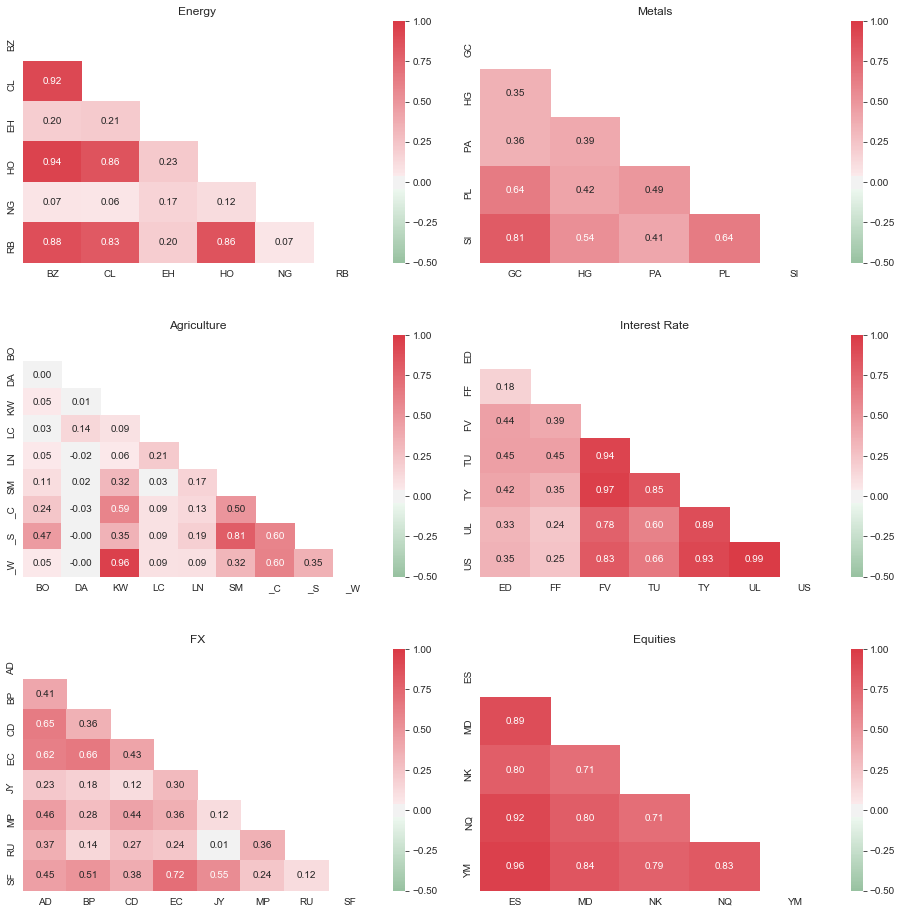

In [13]:
corr_by_sector = {}
for sector, symbols in sectors.groupby('sector').groups.items():
    corr_by_sector[sector] = returns[symbols].corr()

fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=.3, wspace=.05)
rows = np.ceil(len(corr_by_sector.keys())/2)
index = 0
for sector, table in corr_by_sector.items():
    index += 1
    dropSelf = np.zeros_like(table)
    dropSelf[np.triu_indices_from(dropSelf)] = True# Generate Color Map
    ax = fig.add_subplot(rows, 2, index)
    sns.heatmap(table, cmap=colormap, annot=True, fmt=".2f", 
                vmin=-.5, vmax=1, center=0, mask=dropSelf, ax=ax).set_title(sector);

# Single Contract Correlation by Sub-sector

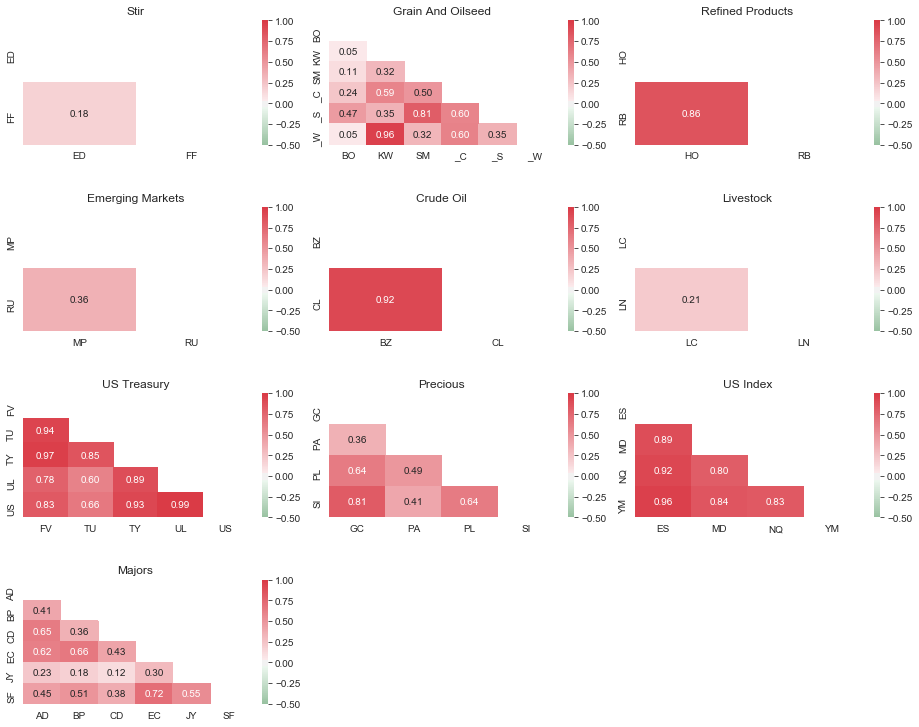

In [14]:
corr_by_sub_sector = {}
for sector, symbols in sectors.groupby('sub-sector').groups.items():
    corr_by_sub_sector[sector] = returns[symbols].corr()

fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=.4, wspace=.1)
rows = np.ceil(len(corr_by_sub_sector.keys())/3)
index = 0
for sector, table in corr_by_sub_sector.items():
    if table.shape == (1,1):
        continue
    index += 1
    dropSelf = np.zeros_like(table)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    ax = fig.add_subplot(rows, 3, index)
    sns.heatmap(table, cmap=colormap, annot=True, fmt=".2f", 
                vmin=-.5, vmax=1, center=0, mask=dropSelf, ax=ax).set_title(sector);

# Sector Indices Correlation

In [15]:
sector_index = pd.DataFrame()
for sector, symbols in sectors.groupby('sector').groups.items():
    df = his[symbols].copy()
    df= df.pct_change()[1:]
    ind = df.apply(lambda x: np.average(x), axis=1)
    sector_index[sector] = ind

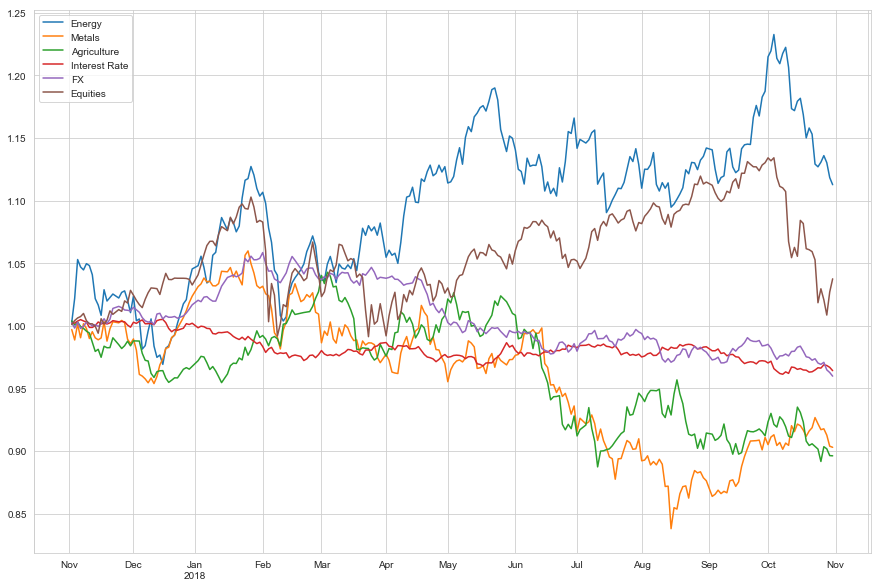

In [16]:
(sector_index + 1).cumprod().plot(grid=True, figsize=(15,10));

In [17]:
sector_returns = np.log(sector_index + 1)

In [18]:
sector_corr = sector_returns.corr()

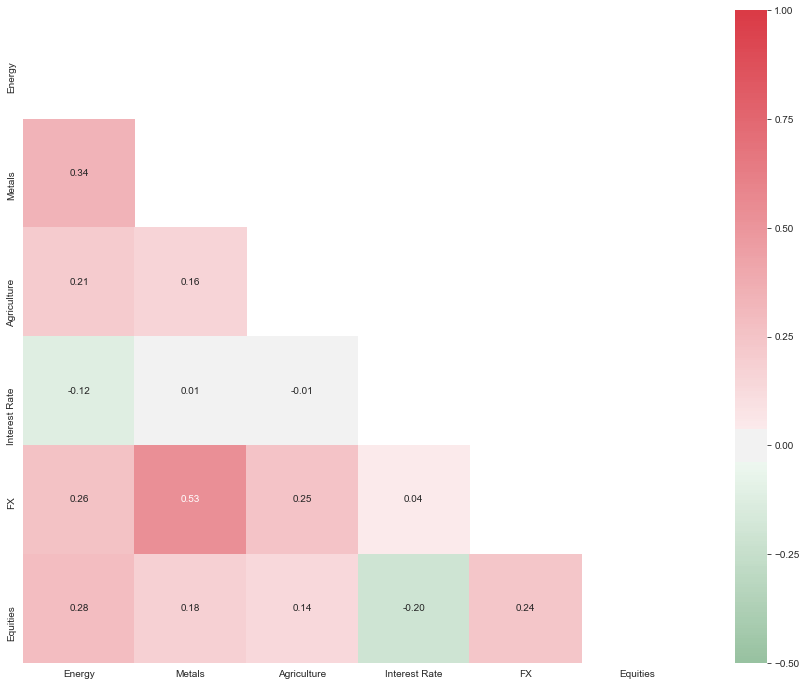

In [19]:
plt.figure(figsize=(15,12))
dropSelf = np.zeros_like(sector_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(sector_corr, cmap=colormap, annot=True, fmt=".2f", vmin=-.5, vmax=1, center=0, mask=dropSelf);

# Sub-sector Indices Correlation

In [20]:
sub_sector_index = pd.DataFrame()
for sector, symbols in sectors.groupby('sub-sector').groups.items():
    df = his[symbols].copy()
    df=df.pct_change()[1:]
    ind = df.apply(lambda x: np.average(x), axis=1)
    sub_sector_index[sector] = ind

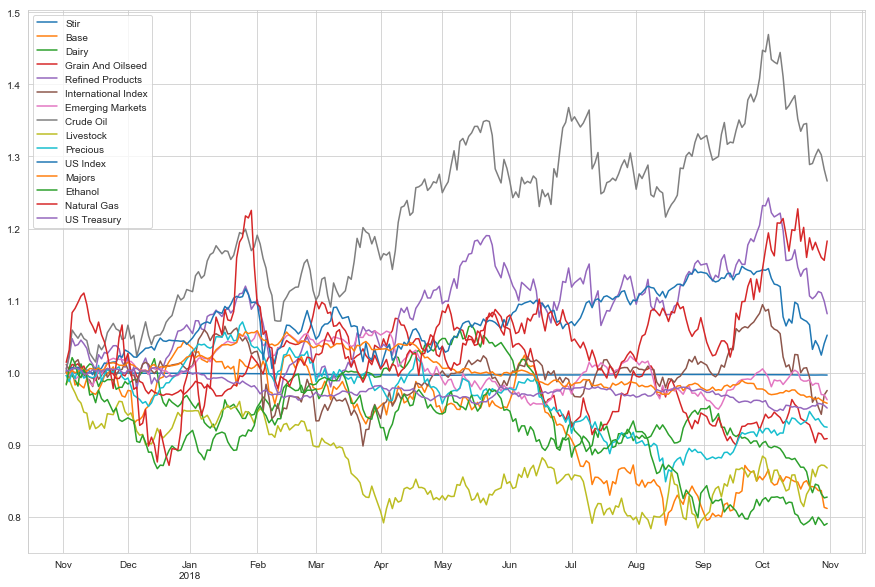

In [21]:
(sub_sector_index + 1).cumprod().plot(grid=True, figsize=(15,10));

In [22]:
sub_sector_returns = np.log(sub_sector_index + 1)

In [23]:
sub_sector_corr = sub_sector_returns.corr()

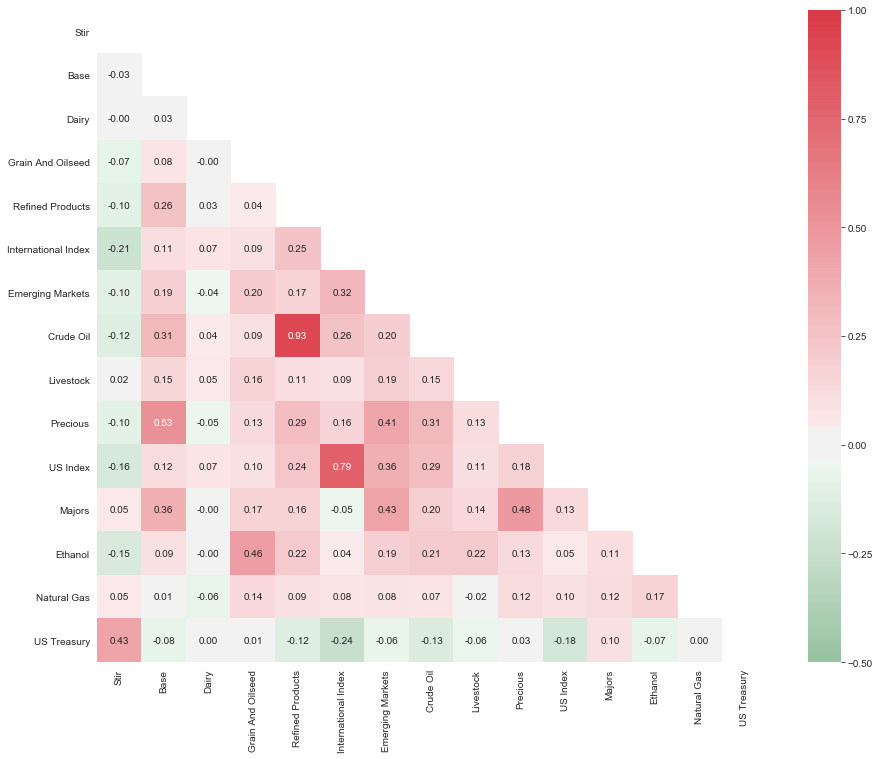

In [24]:
plt.figure(figsize=(15,12))
dropSelf = np.zeros_like(sub_sector_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(sub_sector_corr, cmap=colormap, annot=True, fmt=".2f", vmin=-.5, vmax=1, center=0, mask=dropSelf);

# Correlation Stability Over Time

In [25]:
periods = 2520 * 2 # about 20 years
long_history = history(assets=con, 
                       end_dt=pd.Timestamp('2018-10-31', tz='UTC'),
                       bar_count=periods,
                       frequency='1d',
                       field='price',
                       data_frequency='daily'
                      )
long_history.columns = long_history.columns.map(lambda x: x.root_symbol)
long_history.head()

,ED,TY,FV,TU,US,FF,UL,ES,NQ,YM,...,SM,LC,KW,LN,DA,GC,HG,SI,PL,PA
1998-10-22 00:00:00+00:00,90.8929,63.659382,71.699494,86.276430,67.89245,91.7483,NaN,1202.57,NaN,8600.7,...,39.9,96.081,2809.15,351.344,6.58,476.0,0.7405,8.044,294.5,394.0
1998-10-23 00:00:00+00:00,90.8642,63.362017,71.494659,86.217711,67.62712,91.7580,NaN,1189.83,NaN,8485.6,...,39.5,97.630,2804.86,353.088,6.57,477.0,0.7374,8.031,296.9,398.3
1998-10-26 00:00:00+00:00,90.8021,63.428157,71.406605,86.145570,68.19122,91.7531,NaN,1196.75,NaN,8478.6,...,39.9,97.305,2856.32,344.980,6.56,476.0,0.7303,8.209,297.8,396.4
1998-10-27 00:00:00+00:00,90.8404,63.791662,71.728845,86.322567,68.68846,91.7628,NaN,1189.55,NaN,8423.5,...,39.9,96.892,2819.87,347.421,6.57,478.0,0.7252,8.146,300.3,405.8
1998-10-28 00:00:00+00:00,90.8260,63.923942,71.874977,86.341860,68.65556,91.7628,NaN,1185.68,NaN,8400.5,...,40.1,97.261,2819.87,339.574,6.54,477.3,0.7191,8.316,296.4,404.3


In [26]:
sample = ['ES', 'TY', 'CL', 'GC',] # up to 4 to make number of charts reasonable

In [27]:
def correlation_history(pair, method='pearson'):
    ret = np.log(long_history[pair].pct_change()+1)[1:]
    correlations = pd.Series()
    for i in range(periods-252):
        period_ret = ret[i: 252+i].copy()
        correlations.set_value(period_ret.index[-1], period_ret.corr(method=method).iloc[0,1])
    return correlations

In [28]:
def get_correlations(method='pearson'):
    corr_dict = {}
    for item in sample:
        for other in sample:
            if item == other:
                continue
            key = '{} ({}) vs. {} ({})'.format(item, get_name(item), other, get_name(other))
            corr_dict[key] = correlation_history([item, other], method=method)
    return corr_dict

In [29]:
def draw_charts(corr_dict):
    fig = plt.figure()
    cols = 3
    rows = int(np.ceil(len(corr_dict.keys())/cols))
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(17,10))

    index = 0
    for symbol, table in corr_dict.items():
        row = int(index/3)
        col = index % 3
        ax[row, col].plot(table)
        ax[row, col].grid(True)
        ax[row, col].set_title(symbol)
        index += 1

In [30]:
pearson_corr = get_correlations()
spearman_corr = get_correlations('spearman')

Simple correlations

<Figure size 432x288 with 0 Axes>

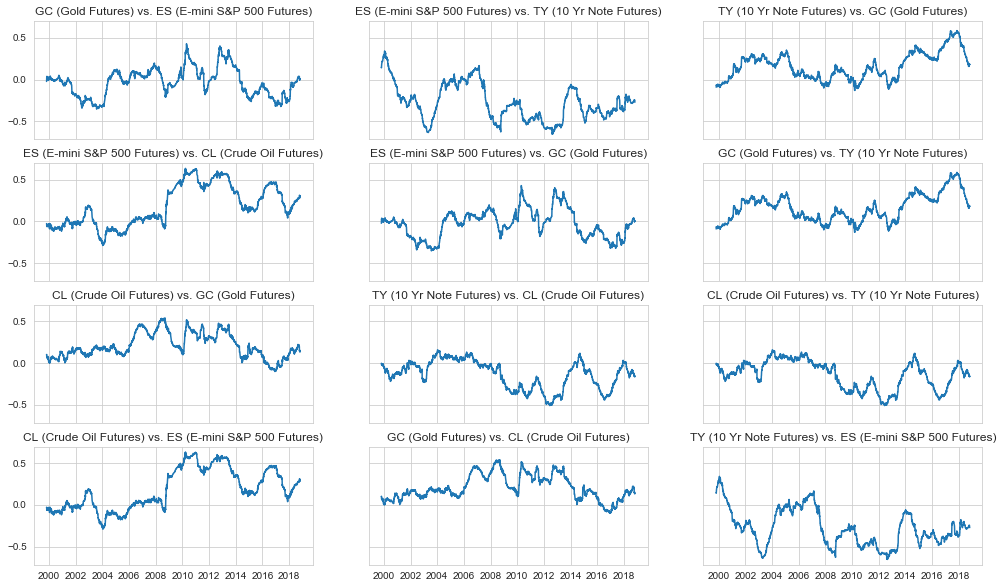

In [31]:
draw_charts(pearson_corr)

Spearman rank correlations

<Figure size 432x288 with 0 Axes>

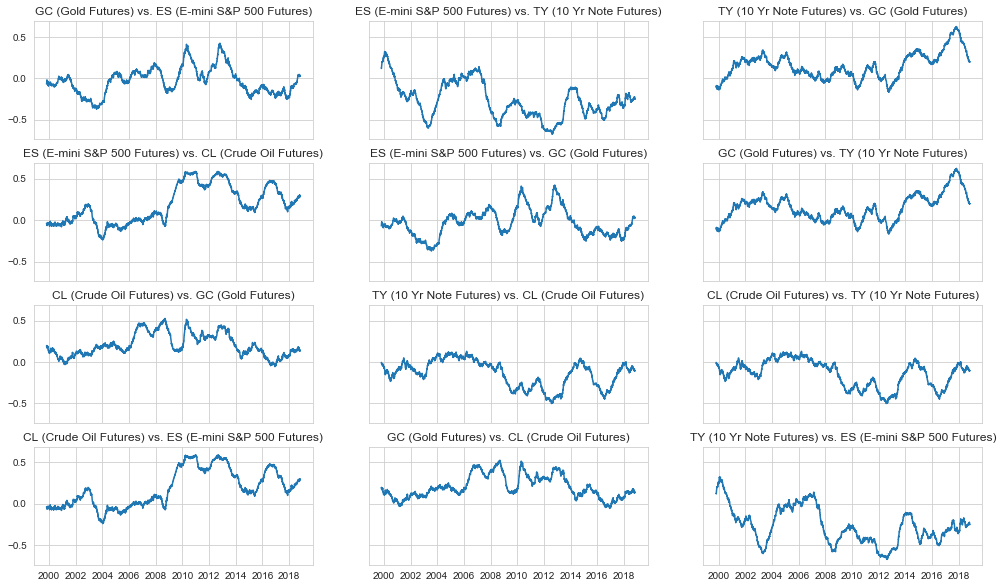

In [32]:
draw_charts(spearman_corr)